# Differential Equation Machine

In [ ]:
# data Generator
import numpy as np

def generate_data(points, dimentions, classes):
    X = np.zeros((points*classes,dimentions))
    y = np.zeros(points*classes, dtype='uint8')
    
    for class_number in range(classes):
        ix = range(points*class_number,points*(class_number+1))
        r = np.linspace(0.0,1,points) # radius
        t = np.linspace(class_number*4,(class_number+1)*4,points) + np.random.randn(points)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = class_number
    return X, y

In [ ]:
import matplotlib.pyplot as plt

X , y = generate_data(100, 2, 3)
print(y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
import math
import numpy as np

E = math.e



def simple_soft_max(input):
    #safe softmax in softmax class
    exponential_values = np.exp(input)
    base = np.sum(exponential_values, axis=1,keepdims=True)
    norm = exponential_values / base
    
        
    return norm



In [2]:
import numpy as np
import nnfs
import math


E = math.e

# sets default configuration for numpy to avoid data type errors
nnfs.init() 

np.random.seed(42)

class DenseLayer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.rand(n_inputs, n_neurons)
        self.biases = np.random.rand(1, n_neurons)

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    # takes the derivaties of the previous layer
    
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

    def __repr__(self):
        # construct and return a string that represents the network
        # architecture
        return "NeuralNetwork: {}".format("-".join(str(l) for l in self.weights))

class ReLu:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        
        #zero the gradient where inputs are negative
        self.dinputs[self.inputs <= 0] = 0

class Sigmoid:
    def forward(self, inputs):
        self.output = 1/(1 + np.exp(-inputs))

class Softmax:
    #safe softmax prevents memory overflow
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class CategoricalCrossEntropyLoss(Loss):
    def forward(self, y_truth,  y_probs):
        samples = len(y_probs)
        y_pred_clipped = np.clip(y_probs, 1e-7, 1-1e-7)
        
        if len(y_truth.shape) == 1: #probabilites for target values, only if categorical labels
            correct_confidences = y_pred_clipped[range(samples), y_truth]
            
        if len(y_truth.shape) == 2: # Masking for one hot encoding
            correct_confidences = np.sum(y_pred_clipped*y_truth, axis=1)
            
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self, y_truth, y_probability):
        samples = len(y_probability)
        if len(y_truth.shape) == 1:
            y_truth = np.eye(y_probability.shape[1])[y_truth]
        
        self.dinputs = -y_truth/ y_probability
        self.dinputs = self.dinputs / samples
        
        
class Fast_CCE_Loss: #composition
    def __init__(self):
        self.activation = Softmax()
        self.loss = CategoricalCrossEntropyLoss()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(y_true, self.output)

    def backward(self, dvalues, y_truth):
        samples = len(dvalues)
        #one-hot encoding conversion
        if len(y_truth.shape) == 2:
            y_truth = np.argmax(y_truth, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_truth] -= 1
        self.dinputs = self.dinputs / samples

# TODO: find a way to better format the layers and activations. maybe do it in a way that
# accepts a dictionary of objects, check for a design pattern
# 
# making a small network

class MyFirstNeuralNetwork:
    def __init__(self, training, y):
        self.data = training
        self.truth = y
        
        self.input_layer = DenseLayer(2,3)
        self.hidden_layer = DenseLayer(3,3)
        self.output_layer = DenseLayer(3,3)
        self.activation1 = ReLu()
        self.activation2 = Fast_CCE_Loss()
        self.alpha = 0.1
        
        
    def forward(self):
        #layer pass
        self.input_layer.forward(self.data)
        self.activation1.forward(self.input_layer.output)
        
        self.hidden_layer.forward(self.activation1.output)
        self.loss = self.activation2.forward(self.hidden_layer.output, self.truth)
        
        #forward pass results
        self.probabilities = self.activation2.output
        self.predictions = np.argmax(self.probabilities, axis=1)
        if len(self.truth.shape) == 2:
            self.truth = np.argmax(self.truth, axis=1)
        self.accuracy = np.mean(self.predictions == self.truth)
        print('loss:', self.loss)
        print('acc:', self.accuracy)
        
    def backward(self):
        self.activation2.backward(self.probabilities, self.truth)
        self.hidden_layer.backward(self.activation2.dinputs)
        self.activation1.backward(self.hidden_layer.dinputs)
        self.input_layer.backward(self.activation1.dinputs)
        
        


### batching 

* allows for calculations to be done in parallel
* distibuted caluclations
* scaleable
* gives more flexability
* Batch training allows for more Efficient training
* 


### common issues

* dead network problem where an initial bias is set to zero and is propegated through the network. the model doesnt learn

# Abstractions

* neuron
* layer
* activation function
* pack propoagation
* gradient decent
* embedder - *ie onehot embedding for normalizing and scaling
* 


### Optimizers
- _Gradient_ : First-order derivative for a multivariate objective function.
- _Step Size (alpha)_ : Hyperparameter that controls how far to move in the search space against the gradient each iteration of the algorithm.
- algorithms that organize how nerons get adjusted to training data
- function that iterates though nerons and changes weights, biases, and activation fucntions to fit data
- Stochastic Gradient Decent
- Adaptive Movement Estimation (Adam)

### Activation Functions Layer

* ReLu
    - efficient
    - popular
* Step - Hevicide Function
    - systen if functions that creates segments with steps (if theta-x > theta-z)
* Sigmoid
    - slower than relu
    - vanishing gradients
* Softmax
    - used for classification

* every neuron in the network has an activation function
* connects two nerons

* why use it?
    - allows for model to segment its self and have each neruon self determine a portion of the data
    - with only linear functions, the network can only learn linear data
    - using non linear functions allows for fitting of more complex data



### Loss

* Categorical Cross Entropy
 - takes an output from the model, does softmax, compares the normalized output to groundtruth, then finally returns how wrong the values are.


### Normalization

* y= e^x
* helps encode data with more quality.
* OneHotEncoding - encodes data into categorical numbers so that linear neral nets can train on classes.
* "Bias Trick": adding an extra dimension to the input data (usallly a 1) to implify bias.

### BackPropagation

* the process of taking the gradient of the loss with respect to weights, and the gradient of the loss with respect to inputs.

* gradient derived from the composite function of all the layers.



"Backpropagation is really one instance of a more general technique called "reverse mode differentiation" to compute derivatives of functions represented in some kind of directed graph form." - 3BlueOneBrown (Deep Learning Chapter 4)

"Essentially, backpropagation evaluates the expression for the derivative of the cost function as a product of derivatives between each layer from left to right – "backwards" – with the gradient of the weights between each layer being a simple modification of the partial products (the "backwards propagated error)."

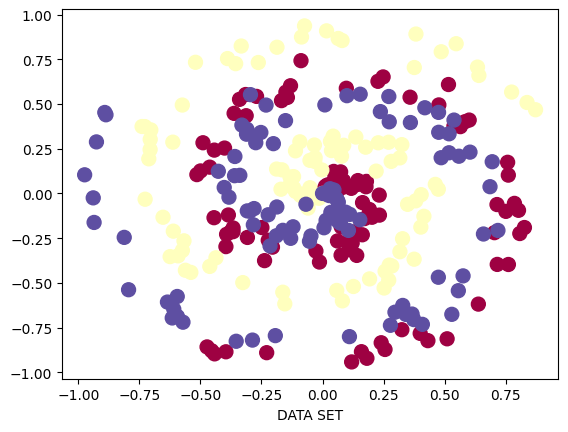

loss: 1.1785840856451923
acc: 0.3333333333333333
[[-0.00223679  0.00166226  0.00057453]
 [-0.00223345  0.00166347  0.00056999]
 [-0.00222877  0.00166265  0.00056613]
 [-0.00222584  0.00165942  0.00056642]
 [-0.00222162  0.00166497  0.00055665]
 [-0.00221724  0.00166453  0.00055271]
 [-0.0022194   0.00165306  0.00056634]
 [-0.00221152  0.00165512  0.00055639]
 [-0.00220462  0.00166247  0.00054215]
 [-0.00220585  0.00165153  0.00055431]
 [-0.00219691  0.00165801  0.00053889]
 [-0.00219376  0.00165527  0.00053849]
 [-0.00219983  0.00164481  0.00055502]
 [-0.00218653  0.00166781  0.00051872]
 [-0.00218061  0.00166235  0.00051826]
 [-0.00218683  0.00164264  0.00054419]
 [-0.00217933  0.00164461  0.00053472]
 [-0.00221521  0.00162707  0.00058814]
 [-0.00218266  0.00163496  0.0005477 ]
 [-0.00217247  0.00163774  0.00053472]
 [-0.00228078  0.00162218  0.0006586 ]
 [-0.00222143  0.00161712  0.00060431]
 [-0.00224318  0.00161343  0.00062975]
 [-0.00218509  0.00162007  0.00056502]
 [-0.00223353  

In [4]:
import numpy as np
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
plt.subplots()

np.random.seed(42)

X, y = spiral_data(samples=100, classes=3)

plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap=plt.cm.Spectral)
plt.xlabel("DATA SET")
plt.show()

nn = MyFirstNeuralNetwork(X, y)

nn.forward()
nn.backward()
print(nn.activation2.dinputs)



# plt.plot(nn.input_layer.output)
# plt.xlabel("input layer")
# plt.show()

# plt.subplot()
# plt.plot(nn.activation2.output)
# plt.xlabel("activation layer")
# plt.show()
# # plt.scatter(X[:, 0], X[:, 1], c= nn.predictions, s=100, cmap=plt.cm.Spectral)
# # plt.xlabel("PREDICTIONS")
# # plt.show()
# plt.subplot()
# plt.scatter(nn.loss_function.dinputs[:, 0], nn.loss_function.dinputs[:, 1])
# plt.xlabel("gradient")
# plt.show()


In [ ]:
loss = CategoricalCrossEntropyLoss()
tensor1 =np.array([[0.1,0.8,0.1],[0.1,0.5,0.4],[0.8,0.1,0.1]])
truth = np.array([1,2,1])
print(loss.calculate(tensor1, truth)) 


In [ ]:
print(y)

In [79]:
print(X)

[[ 0.00000000e+00  0.00000000e+00]
 [ 3.21944972e-04  1.00958785e-02]
 [ 1.01406239e-02  1.74725316e-02]
 [ 2.65020747e-02  1.46940006e-02]
 [ 1.14360163e-02  3.87518257e-02]
 [ 1.91071313e-02  4.67512310e-02]
 [ 5.96790314e-02  1.05597246e-02]
 [ 6.27165437e-02  3.26515697e-02]
 [ 4.38338593e-02  6.78862184e-02]
 [ 8.40679333e-02  3.45983505e-02]
 [ 7.09227771e-02  7.19235763e-02]
 [ 8.55133608e-02  7.09446520e-02]
 [ 1.17804065e-01  2.85408571e-02]
 [ 4.58267257e-02  1.23057097e-01]
 [ 7.41181001e-02  1.20434493e-01]
 [ 1.43003151e-01  5.00693619e-02]
 [ 1.44741133e-01  7.19012469e-02]
 [ 1.63869113e-01 -5.13195954e-02]
 [ 1.77950650e-01  3.73017080e-02]
 [ 1.79767802e-01  6.72050044e-02]
 [ 7.65377581e-02 -1.86960250e-01]
 [ 1.92139819e-01 -8.98760334e-02]
 [ 1.72066405e-01 -1.40626699e-01]
 [ 2.32136816e-01 -9.30482522e-03]
 [ 2.02611968e-01 -1.33108616e-01]
 [ 1.34325907e-01 -2.13835344e-01]
 [ 2.32951865e-01 -1.21268228e-01]
 [ 6.12381697e-02 -2.65763164e-01]
 [ 1.62863359e-01 -2

In [ ]:
# Church Success "Churn" - probability of a church meeting curtain criteria given n features.

# total_members, 
# anual_income, member_frequency(mean%vistors/total_members), social_programs, member_engament, social_media_efficiency_score(mean%retention/platforms), is_membership_increasing, members_youth, members_adults, members_senior, members_family


### Gradient Decent

* consider a chain of nerons
    - how can you find the rate each neron changes given an expected output

* Chain rule: by taking the derivative of composite functions - ie f'(g'(x)) we can understand how each funciton influences the next.

* 

## example of composition in python

In [1]:
# class Component:

#    # composite class constructor
#     def __init__(self):
#         print('Component class object created...')

#     # composite class instance method
#     def m1(self):
#         print('Component class m1() method executed...')


class Composite:

    # composite class constructor
    def __init__(self):

        # creating object of component class
        self.obj1 = Component()
        
        print('Composite class object also created...')

     # composite class instance method
    def m2(self):
      
        print('Composite class m2() method executed...')
    
        # calling m1() method of component class
        self.obj1.m1()


# creating object of composite class
obj2 = Composite()

# calling m2() method of composite class
obj2.m2()

NameError: name 'Component' is not defined